# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

# Table of Contents
1. [Question 1](#Question-1)
2. [Question 2](#Question-2)
3. [Question 3](#Question-3)
4. [Question 4](#Question-4)
5. [Question 5](#Question-5)

In [1]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

# Question 1
-- --
1- Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).

Store the resulting dataset in a pandas DataFrame and answer the following questions:<br /><br />
Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?<br /><br />
Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

## Solution
-- --
We have noticed using postman that there was a txt file containing the data of the page, which was sent along with the webpage data when accessing it. The format inside this file is JSON, and we directly extract the data from it.

In [2]:
URL_top_universities = 'https://www.topuniversities.com'
URL_ranking_tu = URL_top_universities + '/sites/default/files/qs-rankings-data/357051_indicators.txt'

TOP_NUMBER_TU = 200

After inspecting this file using Postman, I have seen that I can retrieve some information about the universities if I go through the data field, and then for each element of the list, I go through each uni field. We get back some html information, from which we can retrieve the university name and its topuniversities link. We also get the rank if we take the overall_rank field instead of uni, the country if we take the location field instead of uni and the region if we take the region field instead of uni. <br />
In the statement, they ask for the region, which we assume to be the same thing as the region field reported in the file. <br/>
After some data inspection, we can see that the data is not completely sorted, as we have the Technische Universität Dresden university (ranked 281) which comes before Texas A&M University (ranked 195). Thus, we go through all universities and keep universities if their ranking is below 200.
<br/>
For the number of faculty members (international and total) and number of students (international and total), we need to retrieve these pieces of information from the details page of each university.

Thus, each time we have a university in the top 200, we use requests on its details page link to retrieve these information. After inspection in Postman, we know that the data is in html format, so we directly use BeautifulSoup on it. We retrieve the text of all fields `<div class='number'>` inside `<div class='total student'>`, inside `<div class="views-row views-row-1">`. By data inspection, we see that for each university we have 2 such entries. However, these 2 student numbers are exactly the same (sometimes there is an additional \n in one of the two, however if we remove the leading and trailing spaces and \n, they are always exactly the same). Thus, we only keep the first one. We do the same for international students, total faculty members and international faculty members, except that instead of looking inside `<div class='total student'>`, we look inside `<div class='total inter'>` for international students, `<div class='total faculty'>` for the total faculty members and `<div class='inter faculty'>` for international faculty members.

In [3]:
# Make the request
r = requests.get(URL_ranking_tu)
json = r.json()

university_name_TU = []
university_data_TU = []

for university in json['data']:
    university_info = BeautifulSoup(university['uni'], 'html.parser')

    rank = BeautifulSoup(university['overall_rank'], 'html.parser').text
    
    if int(rank) <= TOP_NUMBER_TU:
        
        faculty_total_number = 0
        faculty_inter_number = 0
        student_number = 0
        inter_number = 0
        
        link = URL_top_universities + university_info.find('a')['href'] #we directly append the href to the website URL
        university_request = requests.get(link)
        university_soup = BeautifulSoup(university_request.text, 'html.parser')
    
        for panel_numbers in university_soup.find_all('div', {'class': 'views-row views-row-1'}):
            
            for total_faculty in panel_numbers.find_all('div', {'class': 'total faculty'}):
                faculty_number_extract = total_faculty.find('div', {'class': 'number'}).text
                faculty_total_number = int(faculty_number_extract.strip().replace(',', ''))
                
            for inter_faculty in panel_numbers.find_all('div', {'class': 'inter faculty'}):
                faculty_inter_extract = inter_faculty.find('div', {'class': 'number'}).text
                faculty_inter_number = int(faculty_inter_extract.strip().replace(',', ''))
            
            for total_student in panel_numbers.find_all('div', {'class': 'total student'}):
                student_number_extract = total_student.find('div', {'class': 'number'}).text
                student_number = int(student_number_extract.strip().replace(',', ''))
                
            for inter_student in panel_numbers.find_all('div', {'class': 'total inter'}):
                inter_number_extract = inter_student.find('div', {'class': 'number'}).text
                inter_number = int(inter_number_extract.strip().replace(',', ''))

    
        name = university_info.text
        country = BeautifulSoup(university['location'], 'html.parser').text
        region = BeautifulSoup(university['region'], 'html.parser').text
        
        university_name_TU = university_name_TU + [name]
        university_data_TU = university_data_TU + [(int(rank), country, region, faculty_total_number, faculty_inter_number, student_number, inter_number)]

In [4]:
top_universities = pd.DataFrame(university_data_TU, index=university_name_TU, columns=['rank', 'country', 'region', 'total_members', 'int_members', 'total_students', 'int_students'])
top_universities.index.name = 'name'

In [5]:
top_universities.head(12)

,rank,country,region,total_members,int_members,total_students,int_students
name,,,,,,,
Massachusetts Institute of Technology (MIT),1,United States,North America,2982,1679,11067,3717
Stanford University,2,United States,North America,4285,2042,15878,3611
Harvard University,3,United States,North America,4350,1311,22429,5266
California Institute of Technology (Caltech),4,United States,North America,953,350,2255,647
University of Cambridge,5,United Kingdom,Europe,5490,2278,18770,6699
University of Oxford,6,United Kingdom,Europe,6750,2964,19720,7353
UCL (University College London),7,United Kingdom,Europe,6345,2554,31080,14854
Imperial College London,8,United Kingdom,Europe,3930,2071,16090,8746
University of Chicago,9,United States,North America,2449,635,13557,3379


## Q1 a) and b)

For clearer code, we have a function that for a given group (universities, countries or region) will create the necessary columns for the ratios that we need, and display the 10 best entries of each group according to the best corresponding ratio. We chose 10 because displaying all the ranking isn't lisible, we only want to see the best.

In [6]:
def plot_ratios(dataframe, group, title_var, kind='best', top=10):
    """
    dataframe is the data we work on, group the entities we want
    to rank (universities, countries or regions) and title_var the name 
    of the group that will be integrated in the plot's title.
    """
    df = dataframe.copy().fillna(0)
    
    df.reset_index(inplace=True)
    df['ratio_faculty_student'] = df.total_members / df.total_students
    df['ratio_int_student'] = df.int_students / df.total_students
    df.ratio_faculty_student.fillna(0, inplace=True)
    df.ratio_int_student.fillna(0, inplace=True)
    
    df1 = df.copy()
    df1 = df1[['ratio_faculty_student', group]]
    df1.sort_values('ratio_faculty_student', axis=0, ascending= False if kind=='best' else True, inplace=True)
    
    df2 = df.copy()
    df2 = df2[['ratio_int_student', group]]
    df2.sort_values('ratio_int_student', axis=0, ascending=False if kind=='best' else True, inplace=True)
    
    fig, (ax1, ax2) =  plt.subplots(1, 2)

    #if(kind=='best'):
    df1.head(top).plot(x=group, y='ratio_faculty_student', kind='bar', 
    title=str(top) + ' ' + kind + " " +title_var+' in term of faculty members/students ratio', ax=ax1, figsize=(15, 5))

    df2.head(top).plot(x=group, y='ratio_int_student', kind='bar', 
    title=str(top) + ' ' + kind + " "+title_var+' in term of international students ratio', ax=ax2, figsize=(15, 5))
    

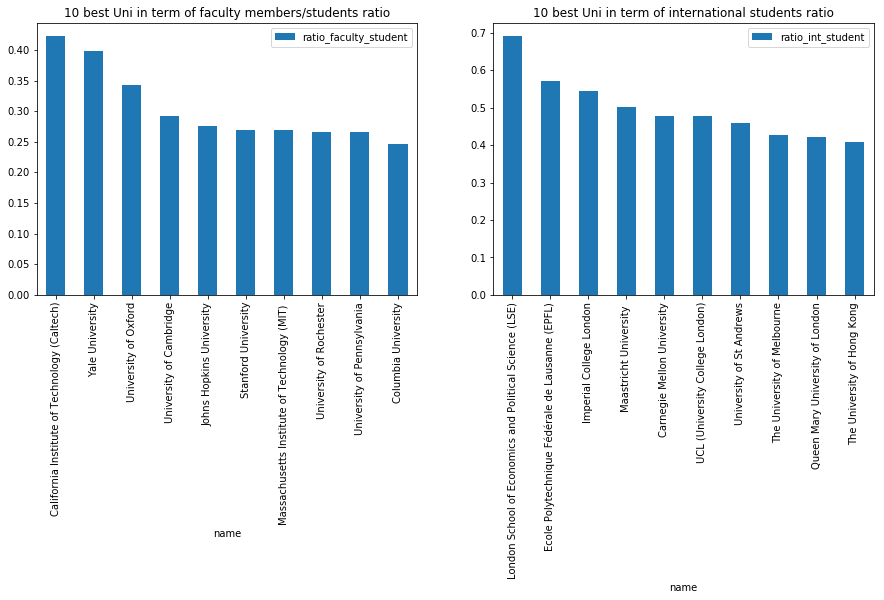

In [7]:
plot_ratios(top_universities, 'name', 'Uni')

We can see here that some university don't have any number : New York University (NYU).

In [8]:
print(top_universities.loc['New York University (NYU)'])

rank                         52
country           United States
region            North America
total_members                 0
int_members                   0
total_students                0
int_students                  0
Name: New York University (NYU), dtype: object


## Q1 c)

Now we do the same for the countries. To aggregate the different numbers by country we think that taking the mean is a fair decision, so that countries with fewer universities will weight the same. Also since the value we are looking for is a ratio, it doesn't matter if a country has universities with more people than others.

In [9]:
country_top = top_universities.copy()
country_top.reset_index(inplace=True)

#Here we take the average to get a fair 
#representation for each country.
country_top = country_top.groupby('country').mean()

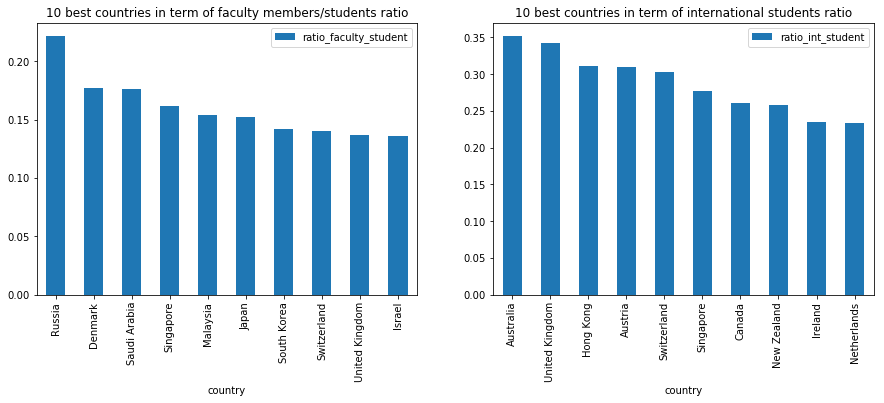

In [10]:
plot_ratios(country_top, 'country', 'countries')

## Q1 d)

For the regions we follow the same reasoning as for the countries.

In [11]:
region_top = top_universities.copy()
region_top.reset_index(inplace=True)

#Here we take the average to get a fair 
#representation for each region.
region_top = region_top.groupby('region').mean()

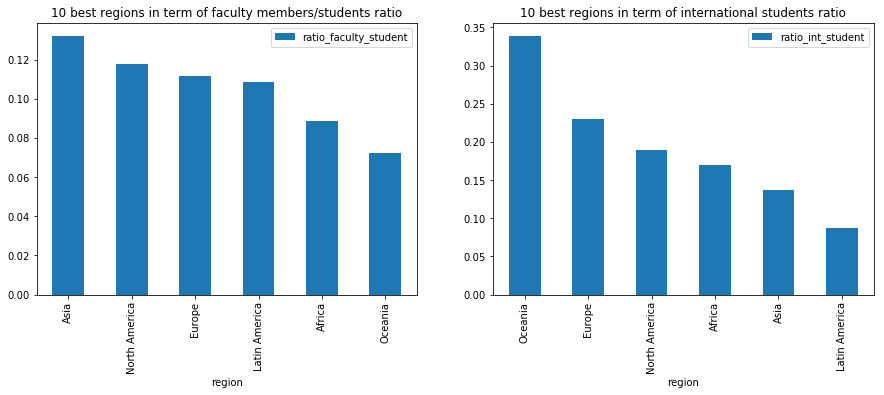

In [12]:
plot_ratios(region_top, 'region', 'regions')

#### Observations

We observe that while Asian and North America have a higher ratio of staff per students, they fall shot on the ratio of international people. On the other side, while Oceania and Europe have very good international ratios, they don't do as well when it comes to the number of staff per students.

Although it's only an hypothesis, it would seems that regions where universities have a rather large staff per student ratio have a worse international ratio, and vice-versa.

# Question 2

We found out that the data for the second website is also extracted from a JSON file, so we also take it directly from it.

In [13]:
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')

In [14]:
#Convert the data into a pandas Dataframe
ranking = pd.DataFrame(dict(r.json())['data'])

Just as before we take the first 200 entries and let their order decide the ranking. We rename some columns to be consistent with the first dataset and categorize some of them. This time the extra stats are directly present in the JSON, so we can already compute the necessary ratios.

In this dataset we are still missing the region and international staff data. The first one we will deduce from the first dataset while the second is not needed.

In [15]:
#Keep only the first 200 universities.
timeshigh = (ranking.head(200))[['rank', 'location', 'name', 'stats_number_students',\
                                 'stats_pc_intl_students', 'stats_student_staff_ratio']]
#Here let the rank be the order of the universities as they were fetched.
#timeshigh['rank'] = range(1, 201)
#Some transformations.
timeshigh['rank'] = timeshigh[['rank']].replace(regex='=', value='').apply(pd.to_numeric).values
timeshigh = timeshigh.set_index('name')
#categorize some columns
#timeshigh['location'] = timeshigh['location'].astype('category')

#tranform the number of students into an integer.
timeshigh['stats_number_students'] = timeshigh['stats_number_students'].apply(lambda s: int(s.replace(',', '')))

#infer the number of international students 
#from the percentage of it times total number of students.
timeshigh['int_students'] = timeshigh['stats_number_students'] * \
                            timeshigh['stats_pc_intl_students'].apply(lambda s: int(s.replace('%', ''))/100.0)
#transform this number into an integer.
timeshigh['int_students'] = timeshigh['int_students'].apply(lambda f : int(f))

#transform ratio staff students into floats.
timeshigh['stats_student_staff_ratio'] = pd.to_numeric(timeshigh['stats_student_staff_ratio'])
#infer the number of staff members from the given ratio.
timeshigh['total_members'] = timeshigh['stats_number_students'] / timeshigh['stats_student_staff_ratio']
#bring back that number to an integer.
timeshigh['total_members'] = timeshigh['total_members'].apply(lambda f : int(f))


timeshigh.rename(columns={'location':'country', 'stats_number_students':'total_students'}, inplace=True)
timeshigh

,rank,country,total_students,stats_pc_intl_students,stats_student_staff_ratio,int_students,total_members
name,,,,,,,
University of Oxford,1,United Kingdom,20409,38%,11.2,7755,1822
University of Cambridge,2,United Kingdom,18389,35%,10.9,6436,1687
California Institute of Technology,3,United States,2209,27%,6.5,596,339
Stanford University,3,United States,15845,22%,7.5,3485,2112
Massachusetts Institute of Technology,5,United States,11177,34%,8.7,3800,1284
Harvard University,6,United States,20326,26%,8.9,5284,2283
Princeton University,7,United States,7955,24%,8.3,1909,958
Imperial College London,8,United Kingdom,15857,55%,11.4,8721,1390
University of Chicago,9,United States,13525,25%,6.2,3381,2181


In [16]:
#drop the columns we don't use
timeshigh.drop(['stats_pc_intl_students', 'stats_student_staff_ratio'],axis=1, inplace=True)

Since we are missing the region columns for this dataset, we will use the first one to create a mapping from countries to regions. We simply groupby the countries, and take the fist region on the list, since the region is always the same for a given country. Then we convert the resulting dataframe directly into a dict() for the next step.

In [17]:
#Now to find a mapping between countries to regions from the first dataset
regions = top_universities[['country', 'region']].copy()
regions = regions.groupby('country').first()
region_map = (regions.to_dict())['region']

Here we just check that every country is in the mapping. We found out that two of them are missing from it, so we just need to add them manually.

In [18]:
#Check if all the countries in the second 
#dataset have their region mapping.
timeshigh.loc[~timeshigh.country.isin(region_map.keys())]['country']
#we see that Luxembourg and the Russian Federations are not in the mapping,
#thus we will add them by hand
region_map['Luxembourg'] = 'Europe'
region_map['Russian Federation'] = 'Europe'

And now we can directly create and fill the region columns.

In [19]:
#Now we can add the region columns

timeshigh['region'] = pd.Series(region_map)[timeshigh['country']].values

## Q2 a) and b)

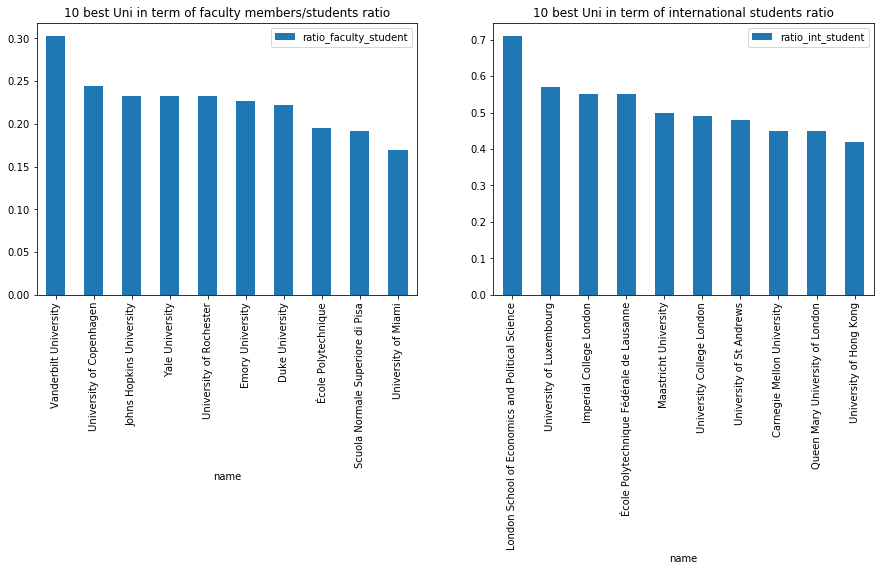

In [20]:
plot_ratios(timeshigh, 'name', 'Uni')

As for the first dataset, we simpy use a groupby and take the mean() of the numbers.

In [21]:
country_th = timeshigh.copy()
country_th.reset_index(inplace=True)

#Here we take the average to get a fair 
#representation for each country.
country_th = country_th.groupby('country').mean()

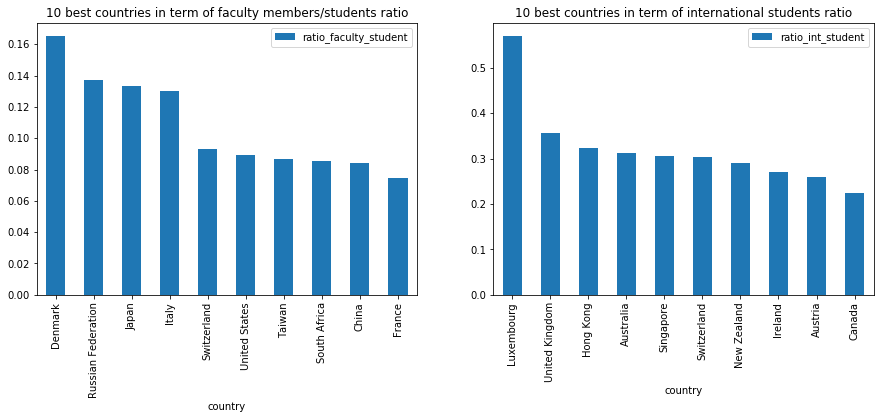

In [22]:
plot_ratios(country_th, 'country', 'countries')

In [23]:
region_th = timeshigh.copy()
region_th.reset_index(inplace=True)

#Here we take the average to get a fair 
#representation for each region.
region_th = region_th.groupby('region').mean()

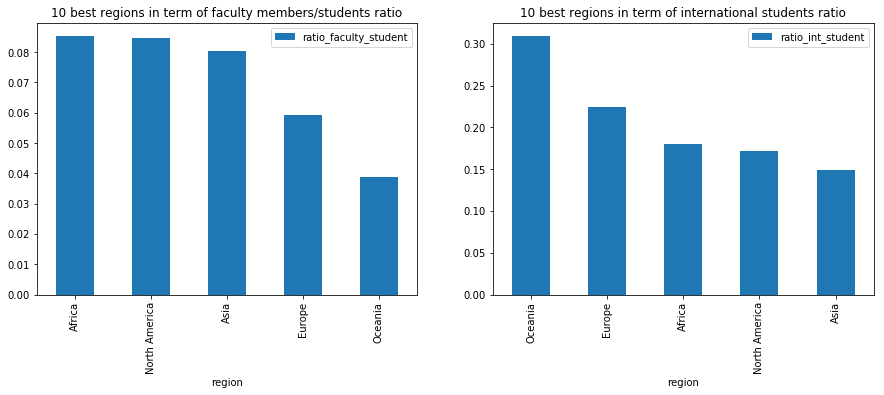

In [24]:
plot_ratios(region_th, 'region', 'regions')

#### Observations
What we observe for this dataset it consistent with the first one, that is regions where universities have a rather large staff per student ratio have a worst international ratio, and vice-versa.

# Question 3

Here we will use an external library to find the ratio of similarity between two strings. The idea is to find the largest contiguous substrings that match between the two strings. A result > 0.6 is usually already pretty similar. 

We first clean the values of words often found in the two strings, and we only consider the strings whose similarity ratio is bigger than 0.7, and clean the results by hand to be sure the matches are correct.

In [25]:
from difflib import SequenceMatcher
import re

def similar(a, b):
    """
    return the ratio of similarity between two strings.
    1 means that the strings are identical, 0 means the string
    don't match at all. As a rule of thumb, 0.6 is an ok match.
    """
    return SequenceMatcher(None, a, b).ratio()

In this first part of cleaning, we create a columns to keep the original name, and apply a result to the names in order to remove the often given first letters of the universities in parenthesis. 

For example "massachusetts institute of technology (MIT)" will be transformed into just "massachusetts institute of technology".

In [26]:
merge_name = pd.DataFrame()
merge_name['orig_name'] = top_universities.copy().index
merge_name['name1'] = merge_name.orig_name.replace(r' \(.*\)', '', regex=True)

This is an helper function to set the string to lowercase, remove common words in the string and then strip the eventual spaces at the beginning and end of the resulting string.

In [27]:
def clean_name(n):
    """
    Clean the given string in preparation of the similarity matching.
    """
    n = n.lower()
    n = re.sub(r'university|institute|université|technology', '', n)
    n = n.strip()
    return n

For each name in the first dataset, we will match the one with the higher similarity ratio in the second dataset. We also store the score of that similarity.

In [28]:
matched_name = []
matched_sim = []

for i, n1 in enumerate(merge_name.name1):
    #clean the name
    n1_c = clean_name(n1)
    best_sim = 0
    match = '?'
    for n2 in timeshigh.copy().index:
        #clean the second name
        n2_c = clean_name(n2)
        sim = similar(n1_c, n2_c)
        #If the similarity is higher, keep it.
        if best_sim < sim:
            match = n2
            best_sim = sim
    matched_name.append(match)
    matched_sim.append(best_sim)

#Now we can assign the columns
merge_name['name2'] = matched_name
merge_name['similarity'] = matched_sim

We only keep the match whose similarity ratio is higher or equal to 0.7.

After manualy checking the list of matches, we remove those who are incorrectly matched.

In [29]:
to_remove = ['Ecole normale supérieure, Paris',
'National Tsing Hua University',
'University of Bergen',
'University College Dublin',
'University of Reading',
'The University of Hong Kong',
'University of Technology Sydney',
]
#keep only the best matches.
merge = merge_name.loc[(merge_name.similarity >= 0.7)]
merge = merge.loc[~merge.name1.isin(to_remove)]

In [30]:
#check we didn't assign the same university to two names
merge.name2.loc[merge.name2.duplicated()].empty

True

This step will leave us with 149 correctly matched names. We discard the others, some of them don't have any match at all anyway. 

We could have gotten a better match by doing everything manually, but we think the goal of this exercise what to try to get the most matches with a minimal manual intervention.

We create a map from the orignial names of the first dataset to the matched names of the second dataset, replace the names in the fist dataset using this mapping, and finally do an inner join on the names between the two datasets.

In [31]:
uni_map = merge[['orig_name', 'name2']].set_index('orig_name').to_dict()['name2']

top = top_universities.copy().reset_index()
top.name.replace(uni_map, inplace=True)

merged = pd.merge(top, timeshigh.reset_index(), 'inner', 'name', suffixes=('_top', '_times'))
merged#.head()

,name,rank_top,country_top,region_top,total_members_top,int_members,total_students_top,int_students_top,rank_times,country_times,total_students_times,int_students_times,total_members_times,region_times
0,Massachusetts Institute of Technology,1,United States,North America,2982,1679,11067,3717,5,United States,11177,3800,1284,North America
1,Stanford University,2,United States,North America,4285,2042,15878,3611,3,United States,15845,3485,2112,North America
2,Harvard University,3,United States,North America,4350,1311,22429,5266,6,United States,20326,5284,2283,North America
3,California Institute of Technology,4,United States,North America,953,350,2255,647,3,United States,2209,596,339,North America
4,University of Cambridge,5,United Kingdom,Europe,5490,2278,18770,6699,2,United Kingdom,18389,6436,1687,Europe
5,University of Oxford,6,United Kingdom,Europe,6750,2964,19720,7353,1,United Kingdom,20409,7755,1822,Europe
6,Imperial College London,8,United Kingdom,Europe,3930,2071,16090,8746,8,United Kingdom,15857,8721,1390,Europe
7,University of Chicago,9,United States,North America,2449,635,13557,3379,9,United States,13525,3381,2181,North America
8,ETH Zurich – Swiss Federal Institute of Techno...,10,Switzerland,Europe,2477,1886,19815,7563,10,Switzerland,19233,7308,1317,Europe
9,"Nanyang Technological University, Singapore",11,Singapore,Asia,4338,2993,25738,7251,52,Singapore,25499,7904,1564,Asia


# Question 4

For this question we needed unified data, so to make this we took the average of the duplicated columns from the two datasets, which is we think a fair choice.

We then compute again the ratios we will work on.

To get an idea of the relation between the columns, the pd.corr() function and some plots are very helpful.

,int_members,total_members_avg,int_students_avg,total_students_avg,int_students_ratio,int_members_ratio
int_members,1.000000,0.517546,0.546385,0.295200,0.313095,0.617000
total_members_avg,0.517546,1.000000,0.314039,0.618534,-0.228731,-0.229015
int_students_avg,0.546385,0.314039,1.000000,0.609142,0.495329,0.319308
total_students_avg,0.295200,0.618534,0.609142,1.000000,-0.264698,-0.202795
int_students_ratio,0.313095,-0.228731,0.495329,-0.264698,1.000000,0.624499
int_members_ratio,0.617000,-0.229015,0.319308,-0.202795,0.624499,1.000000


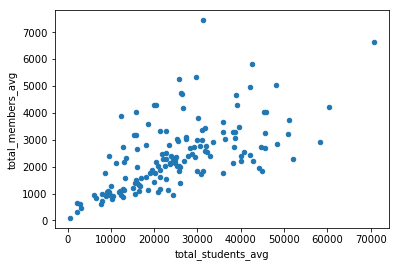

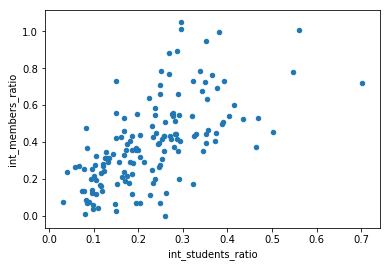

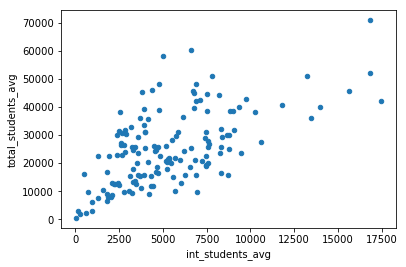

In [32]:
explore = merged.copy()

explore['int_students_avg'] = (explore['int_students_top'] + explore['int_students_times'])/2
explore['total_students_avg'] = (explore['total_students_top'] + explore['total_students_times'])/2
explore['total_members_avg'] = (explore['total_members_top'] + explore['total_members_times'])/2

explore['int_students_ratio'] = explore['int_students_avg']/explore['total_students_avg']
explore['int_members_ratio'] = explore['int_members']/explore['total_members_avg']

explore = explore[['name', 'country_top', 'region_top', 'int_members', 'total_members_avg',
                   'int_students_avg', 'total_students_avg', 'int_students_ratio', 'int_members_ratio']]

explore.plot('total_students_avg', 'total_members_avg', kind='scatter')
explore.plot('int_students_ratio', 'int_members_ratio', kind='scatter')
explore.plot('int_students_avg', 'total_students_avg', kind='scatter')
explore.corr()

We can see that there is a correlation of 0.618534 between the number of students and the number of staff. It seems fair since the more students an university has, the bigger it is, and consequently the more staff it can have. Furthermore, we also see a correlation between the number students and the number of international students, which makes sense as when there are more students, there is a bigger proportion of international students.

There is also a correlation of 0.624499	 between the ratio of international students and the ratio of international staff. This also seems fair since the more iternational an university is, the more international people of all categories it will have.

There is also a strong correlation between the international staff ratio and the number of staff, for example, but this one is obviously the result of the equational relation between those two, since one is computed from the other.

# Question 5

To estimate the true ranking, we decided to take the average of the two given ranks, to which we add the difference in ranking divided by 5. 

There is no real way to decide for the ranking, but we decided that to take the average and to penalized universities that have a high ranking difference was a good estimation. The division by 5 is entirely subjective.

One could argue that the estimation is utterly wrong since EPFL doesn't take the top of the ranking ;)

In [36]:
ranked = merged.copy()[['rank_top', 'rank_times']].assign(name=merged.name) #'name'
ranked['fair_rank'] = (ranked.rank_top + ranked.rank_times)/2 + np.abs(ranked.rank_top - ranked.rank_times)/5

ranked = ranked.sort_values('fair_rank')
ranked.index = range(1, 150)

ranked

,rank_top,rank_times,name,fair_rank
1,2,3,Stanford University,2.7
2,4,3,California Institute of Technology,3.7
3,1,5,Massachusetts Institute of Technology,3.8
4,5,2,University of Cambridge,4.1
5,6,1,University of Oxford,4.5
6,3,6,Harvard University,5.1
7,8,8,Imperial College London,8.0
8,9,9,University of Chicago,9.0
9,10,10,ETH Zurich – Swiss Federal Institute of Techno...,10.0
10,13,7,Princeton University,11.2
